In [1]:
import numpy as np
import scipy


def generate_parameters(n=10, max_logit=2, max_count=20, logit_mean=0.1):
    logits = logit_mean + np.random.uniform(-max_logit, max_logit, n)
    probabilities = scipy.special.expit(logits)
    counts = 1 + np.random.exponential(scale=max_count, size=n).astype(int)
    return probabilities, counts

generate_parameters()

(array([0.77256951, 0.37169787, 0.47755886, 0.23376967, 0.27758219,
        0.29331637, 0.66119388, 0.59163514, 0.40212556, 0.768516  ]),
 array([37, 24, 12,  8, 18, 58, 64, 17, 13,  4]))

In [2]:
def generate_experiments(k=1000, **kwargs):
    probabilities, counts = generate_parameters(**kwargs)
    
    target = []
    for p, c in zip(probabilities, counts):
        target.append(
            np.random.binomial(n=c, p=p, size=k)
        )
    target = np.column_stack(target)
    total = np.column_stack([counts] * k).T

    return target, total, probabilities

target, total, probabilities = generate_experiments(1000)

In [3]:
def get_optimal(target, total, probabilities):
    return [np.argmax(probabilities)] * total.shape[0]

np.mean(probabilities[get_optimal(target, total, probabilities)]).round(3)

0.845

In [4]:
def get_argmax(target, total, probabilities):
    return np.argmax(target / total, axis=1)

np.mean(probabilities[get_argmax(target, total, probabilities)]).round(3)

0.805

In [5]:
def get_random(target, total, probabilities):
    return np.random.randint(0, total.shape[1] - 1, total.shape[0])

np.mean(probabilities[get_random(target, total, probabilities)]).round(3)

0.62

In [6]:
strategies = [get_random, get_argmax, get_optimal]

In [ ]:

def get_argmax_std_diff(target, total, probabilities, alpha=1.0):
    p_estimate = target / total
    q_estimate = 1 - p_estimate
    std = (p_estimate * (1 - q_estimate) / total) ** 0.5
    return np.argmax(p_estimate - std * alpha, axis=1)

def maximize_posteriori_expected_value(n_hands: int, counts: ndarray, rewards: ndarray, alpha: float, beta: float) -> int:
    """Assuming apriori distribution on p_i ~ Beta(alpha, beta),
    and using that beta distribution is the conjugate to binomial r_i ~ Bin(p_i, n_i),
    evaluates hand index that maximizes expected value of posteriori distribution P(p_i | c_i, r_i) ~ Beta(alpha + k_i, alpha + beta + n_i)
    that is, (alpha + r_i) / (alpha + beta + n_i).
    
    n_hands: int - number of variants to choose from
    counts: 1-dim numpy array, len(counts) == n_hands. How many times we used each hand
    rewards: 1-dim numpy array, len(counts) == n_hands. Cumulative reward received from each hand. 
        By its nature 0 <= rewards[i] <= counts[i].
        
    Returns: index: int, from 0 to n_hands - 1 - index of chosen hand.
    """
    expected_posteriori_probabilities = (alpha + rewards) / (alpha + beta + counts)
    return int(np.argmax(expected_posteriori_probabilities))

uniform_prior_strategy = functools.partial(maximize_posteriori_expected_value, alpha=1, beta=1)

In [7]:
import pandas as pd
from tqdm.auto import tqdm
from joblib import Parallel, delayed, wrap_non_picklable_objects
import itertools
from functools import partial


def check_strategies_once(strategies=[get_random, get_optimal], n_set=[10, 100, 1000], **kwargs):
    results = []

    for n in n_set:
        target, total, probabilities = generate_experiments(n=n, **kwargs)
        experiment_result = {'n': n}
        rank = pd.Series(probabilities).rank(ascending=False, method='first').values
        rank = (rank - 1) / rank.shape[0]
        for strategy in strategies:
            name = ''
            try:
                name = strategy.__name__
            except AttributeError:
                name = f'{strategy.func.__name__}:{strategy.keywords}'

            score = np.mean(probabilities[strategy(target, total, probabilities)])
            mean_rank = np.mean(rank[strategy(target, total, probabilities)])
            experiment_result[name] = score
            experiment_result[f'{name}_rank'] = mean_rank
        results.append(experiment_result)
    return results

def check_strategies_multi(strategies=[get_random, get_optimal], n_set=[10, 100, 1000], n_repeats=10, **kwargs):
    results = []
    print(n_set)

    results = Parallel(n_jobs=-1, verbose=1)(delayed(check_strategies_once)(
        strategies=strategies, n_set=n_set, **kwargs
    ) for i in tqdm(range(n_repeats)))

    return list(itertools.chain.from_iterable(results))

strategies = [get_argmax, get_optimal] # get_random
for alpha in np.linspace(1.0, 3.0, 11):
    s = partial(get_argmax_std_diff, alpha=alpha)
    strategies.append(
        s
    )

results = check_strategies_multi(
    strategies=strategies, 
    n_set=np.logspace(1, 4, 50).astype(int),
    max_logit=3,
    k=1000,
    n_repeats=80,
)

[   10    11    13    15    17    20    23    26    30    35    40    47
    54    62    71    82    95   109   126   145   167   193   222   255
   294   339   390   449   517   596   686   790   910  1048  1206  1389
  1599  1842  2120  2442  2811  3237  3727  4291  4941  5689  6551  7543
  8685 10000]


  0%|          | 0/80 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 27.3min finished


In [8]:
results = pd.DataFrame(results).set_index('n').sort_index()
results.sample(3).T

n,6551,1389,1389
get_argmax,0.863841,0.900258,0.841838
get_argmax_rank,0.160269,0.103950,0.255322
get_optimal,0.956889,0.956858,0.956610
get_optimal_rank,0.000000,0.000000,0.000000
get_argmax_std_diff:{'alpha': 1.0},0.944019,0.936529,0.941474
get_argmax_std_diff:{'alpha': 1.0}_rank,0.043764,0.059120,0.054468
get_argmax_std_diff:{'alpha': 1.2},0.942668,0.934894,0.942340
get_argmax_std_diff:{'alpha': 1.2}_rank,0.048019,0.063369,0.052278
get_argmax_std_diff:{'alpha': 1.4},0.941764,0.933101,0.942759
get_argmax_std_diff:{'alpha': 1.4}_rank,0.050855,0.067873,0.051374


In [9]:
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(11.7,8.27)})

In [10]:
results[[s for s in results.columns if s.endswith('_rank')]].mean(axis=0).T.sort_values().round(4)

get_optimal_rank                                          0.0000
get_argmax_std_diff:{'alpha': 1.0}_rank                   0.0612
get_argmax_std_diff:{'alpha': 1.2}_rank                   0.0646
get_argmax_std_diff:{'alpha': 1.4}_rank                   0.0684
get_argmax_std_diff:{'alpha': 1.6}_rank                   0.0722
get_argmax_std_diff:{'alpha': 1.8}_rank                   0.0761
get_argmax_std_diff:{'alpha': 2.0}_rank                   0.0801
get_argmax_std_diff:{'alpha': 2.2}_rank                   0.0842
get_argmax_std_diff:{'alpha': 2.4000000000000004}_rank    0.0884
get_argmax_std_diff:{'alpha': 2.6}_rank                   0.0926
get_argmax_std_diff:{'alpha': 2.8}_rank                   0.0969
get_argmax_std_diff:{'alpha': 3.0}_rank                   0.1014
get_argmax_rank                                           0.1878
dtype: float64

In [11]:
results[[s for s in results.columns if not s.endswith('_rank')]].mean(axis=0).T.sort_values().round(4)

get_argmax                                           0.8360
get_argmax_std_diff:{'alpha': 3.0}                   0.9076
get_argmax_std_diff:{'alpha': 2.8}                   0.9106
get_argmax_std_diff:{'alpha': 2.6}                   0.9134
get_argmax_std_diff:{'alpha': 2.4000000000000004}    0.9160
get_argmax_std_diff:{'alpha': 2.2}                   0.9185
get_argmax_std_diff:{'alpha': 2.0}                   0.9208
get_argmax_std_diff:{'alpha': 1.8}                   0.9230
get_argmax_std_diff:{'alpha': 1.6}                   0.9251
get_argmax_std_diff:{'alpha': 1.4}                   0.9272
get_argmax_std_diff:{'alpha': 1.2}                   0.9291
get_argmax_std_diff:{'alpha': 1.0}                   0.9308
get_optimal                                          0.9523
dtype: float64

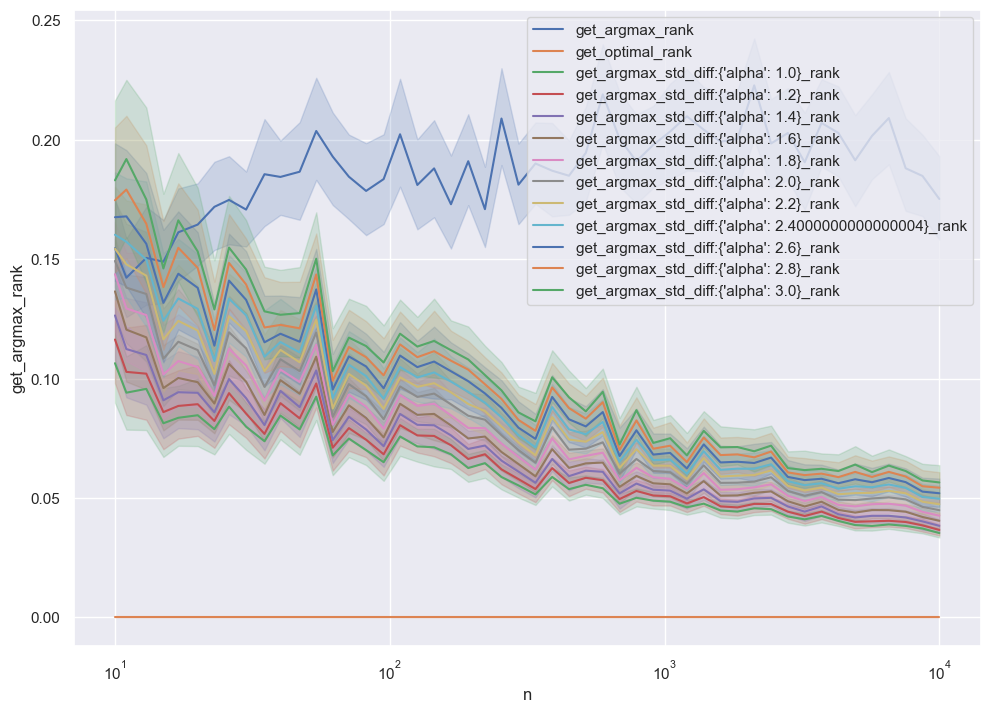

In [12]:
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(11.7,8.27)})

for strategy_name in [s for s in results.columns if s.endswith('_rank')]:
    plot = seaborn.lineplot(results, x='n', y=strategy_name, label=strategy_name)
    plot.set(xscale='log')

_ = plt.legend()

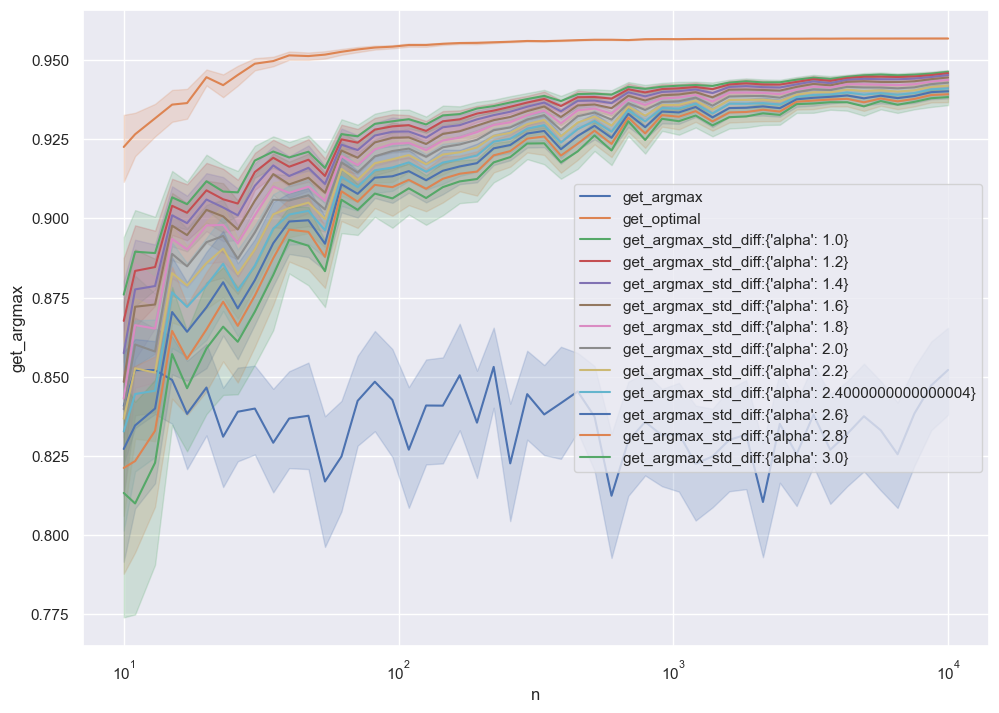

In [13]:
import seaborn
from matplotlib import pyplot as plt

seaborn.set(rc={'figure.figsize':(11.7,8.27)})

for strategy_name in [s for s in results.columns if not s.endswith('_rank')]:
    plot = seaborn.lineplot(results, x='n', y=strategy_name, label=strategy_name)
    plot.set(xscale='log')

_ = plt.legend()